In [1]:
import sys,os
import time
import pandas as pd
import pickle
import re
import matplotlib.pyplot as plt
import seaborn as sns
import bindome as bd

from tqdm.notebook import tqdm
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import warnings
warnings.filterwarnings('ignore')

# to stop cleanly
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

def stop_if_path_exists(path):
    if os.path.exists(path):
        print(f'Path {path} exists. Stopping.')
        raise StopExecution

## Scraping

Skip to Analysis section if scraped data is ready.

In [2]:
base_url = 'https://motifcentral.org/fit/'
DRIVER = webdriver.Firefox # TODO change to Chrome/Firefox/Safari based on local availability
SCRAPE_RESULTS_DIR = '/home/icb/ege.erdogan'
bd.constants.ANNOTATIONS_DIRECTORY = '/lustre/groups/ml01/datasets/annotations'
MUBIND_RESULTS_DIR = '/home/icb/ege.erdogan/mubind-pipeline/OUTPUTS/23-01-09_151632/snakemake'

data_keys = [
    'Pearson\'s r2 (k-mer)',
    'Pearson\'s r2 (affinity-binned)',
    'Maximum predicted bin enrichment',
    'Maximum observed bin enrichment',
    'Partial Pearson\'s r2',
    'Predicted partial max bin enrichment',
    'Observed partial max bin enrichment',
    'R2',
    'Enrichment',
    'R2, partial',
    'Enrichment, partial',
    ]

Next cell fills `ids` to use later.

In [3]:
try:
    browser = None
    stop_if_path_exists(f'{SCRAPE_RESULTS_DIR}/probound_ids.pkl')
    browser = DRIVER()
    browser.get('https://motifcentral.org/home')

    el = WebDriverWait(browser, timeout=10).until(
        EC.text_to_be_present_in_element((By.TAG_NAME, 'body'), 'Complex')
    )

    num_pages = int(re.search('Number of Pages: [0-9]+', browser.page_source).group(0).split(' ')[-1])
    print('num_pages', int(num_pages))
    ids = []
    for page in tqdm(range(num_pages)):
        b1 = browser.find_elements(By.XPATH, '//span[@class = "badge badge-pill badge-success"]')
        b2 = browser.find_elements(By.XPATH, '//span[@class = "badge badge-pill badge-dark"]')
        b3 = browser.find_elements(By.XPATH, '//span[@class = "badge badge-pill badge-light ng-star-inserted"]')
        b4 = browser.find_elements(By.XPATH, '//span[@class = "badge badge-pill badge-primary"]')
        for a, b, c, d in zip(b1, b2, b3, b4):
            val = (d.text, a.text, b.text, int(c.text[1:]))
            print(val)
            ids.append(val)
        
        # click next page
        if page != num_pages - 1: # don't click next page on last page
            button = browser.find_element(By.XPATH, '//button[@aria-label = "Next page"]')
            button.click()
        time.sleep(2)
        if page == 3: 
            break
            
    browser.quit()
    with open(f'{SCRAPE_RESULTS_DIR}/probound_ids.pkl', 'wb+') as f:
        pickle.dump(ids, f)
    print(f'Collected {len(ids)} ids')
except Exception as e:
    print(e)
    if browser is not None:
        browser.quit()

Path /home/icb/ege.erdogan/probound_ids.pkl exists. Stopping.



Parse useful values from HTML page for each id

In [4]:
from tqdm import tqdm

browser = None
stop_if_path_exists(f'{SCRAPE_RESULTS_DIR}/probound_id_results.pkl')
browser = DRIVER()

id_results = dict() # (int, dict) dict
try:
    for x, y, id in tqdm(ids):
        if id in id_results.keys():
            continue

            browser.get(base_url + str(id))

            el = WebDriverWait(browser, timeout=20).until(
                EC.text_to_be_present_in_element((By.ID, 'selexKMerPrediction'), 'Pearson')
            )

            rows = browser.find_elements(By.CLASS_NAME, "row")

            # collect rows containing the lines from data_keys
            result_rows = set()
            for key in data_keys:
                for r in rows:
                    if key in r.text and '_' not in r.text: 
                        if key == 'Predicted partial max bin enrichment':
                            # hacky fix because colon is missing from webpage
                            idx = r.text.index('nt') + 2
                            result_rows.add(r.text[:idx] + ':' + r.text[idx:])
                        else:
                            result_rows.add(r.text)

            results = dict() # (str, str) dict
            for row in result_rows:
                k, v = row.split(':')
                results[k] = v.strip()

            id_results[id] = results
            time.sleep(2)

    with open(f'{SCRAPE_RESULTS_PATH}/probound_id_results.pkl', 'wb') as f:
        pickle.dump(id_results, f)
        print(f'Total collected: {len(id_results)}')
        
except Exception as e:
    print(e)
    browser.quit()

Path /home/icb/ege.erdogan/probound_id_results.pkl exists. Stopping.


## Analysis

Next cell loads the scraped data and defines some simple helper methods. No need to modify data-loading code unless scraping method changes.

In [5]:
with open(f'{SCRAPE_RESULTS_DIR}/probound_ids.pkl', 'rb+') as f:
    ids = pd.DataFrame(pickle.load(f), columns=['tf', 'study', 'library', 'id'])
    print(ids.info())

cols = [
    'id', # the rest is sorted alphabetically
    'enrichment',
    'enr_partial',
    'max_obs_bin_enr',
    'max_pred_bin_enr',
    'obs_part_max_bin_enr',
    'part_pearson_r2',
    'pearson_r2_affinity',
    'pearson_r2_kmer',
    'pred_part_max_bin_enr',
    'r2',
    'r2_partial'
]
    
with open(f'{SCRAPE_RESULTS_DIR}/probound_id_results.pkl', 'rb+') as f:
    id_results = pickle.load(f)
    # since we know the first item contains all common keys
    valid_keys = list(id_results.values())[0].keys()
    
    # remove keys not present in all values from id_results and sort remaining ones
    for k1, v1 in id_results.items():
        del_keys = [k2 for k2 in v1.keys() if k2 not in valid_keys]
        for k in del_keys:
            del v1[k]
        id_results[k1] = sorted(v1.items())
    
    # we have a dict with ids as keys; convert it to list of lists with ids as the first elements for each item
    as_tuple_list = [[k] + [x[1] for x in v] for k, v in id_results.items()]
    pb_results = pd.DataFrame(as_tuple_list, columns=cols)
    print(pb_results.info())
    
assert len(ids) == len(pb_results)

bd_data = bd.bindome.datasets.SELEX.get_data()

def tfs_in_study(study):
    return ids[ids['study'].str.contains(study)]['tf']


def id_results(id):
    return pb_results[pb_results['id'] == int(id)]


def mubind_tf_results(tf, dataset='SELEX', sep=','):
    path = f'{MUBIND_RESULTS_DIR}/{tf}/{dataset}/fit_model/metrics.tsv'
    return pd.read_csv(path, sep=sep)


def pb_tf_results(tf):
    tf_ids = ids[ids['tf'] == tf]['id']
    return pb_results[pb_results['id'].isin(tf_ids)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 872 entries, 0 to 871
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tf       872 non-null    object
 1   study    872 non-null    object
 2   library  872 non-null    object
 3   id       872 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 27.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 872 entries, 0 to 871
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     872 non-null    int64 
 1   enrichment             872 non-null    object
 2   enr_partial            872 non-null    object
 3   max_obs_bin_enr        872 non-null    object
 4   max_pred_bin_enr       872 non-null    object
 5   obs_part_max_bin_enr   872 non-null    object
 6   part_pearson_r2        872 non-null    object
 7   pearson_r2_affinity    872 non-null    object
 8 

In [6]:
ids.head()

,tf,study,library,id
0,abd-A,Nitta2015,abd-A_KU_TCACTT40NTTG,15412
1,Abd-B,Slattery2011,AbdB.16mer2_rep1,11232
2,AC020909.1,Jolma2013,SPIB_ESAK_TGTCTA20NTCG,16273
3,Aef1,Nitta2015,Aef1_KY_TCGAGT40NACT,16388
4,al,Nitta2015,al_KY_TTTCAA40NTGA,15421


In [7]:
pb_results.head()

,id,enrichment,enr_partial,max_obs_bin_enr,max_pred_bin_enr,obs_part_max_bin_enr,part_pearson_r2,pearson_r2_affinity,pearson_r2_kmer,pred_part_max_bin_enr,r2,r2_partial
0,15412,8.00,"8.26, 4.76, 5.78",20.57,16.60,"21.40, 9.79, 16.05","0.99, 0.96, 0.98",0.99,0.73,"16.75, 11.00, 14.61",-0.00,"0.90, 0.92, -0.00"
1,11232,2.00,"2.61, 2.27, 2.35",8.32,9.89,"14.77, 5.76","0.97, 0.94",0.99,0.50,"13.79, 6.28",0.97,"0.97, 0.93"
2,16273,35.00,"38.26, 46.63, 35.50, 3.25",11.69,12.80,"81.47, 78.61, 68.65, 5.87","0.97, 0.99, 0.99, 0.87",1.00,0.81,"143.58, 121.44, 31.27, 4.95",0.98,"0.79, 0.93, 0.98, 0.77"
3,16388,40.00,"40.46, 3.72, 2.29",54.99,46.98,"76.73, 47.90, 25.55","0.99, 0.99, 0.94",0.99,0.75,"94.89, 71.81, 8.99",0.98,"0.98, 0.98, 0.96"
4,15421,2.00,"2.82, 2.92, 2.71",13.74,12.61,"12.85, 12.86, 10.28","0.97, 0.98, 0.98",0.99,0.60,"14.24, 7.68, 8.38",0.98,"0.98, 0.98, 0.98"


In [8]:
bd_data.head()

,filename,library,batch,cycle,tf.name,accession,path
0,GATA4_2_R46777.txt.gz,R46777,R46777,R46777,GATA4,cardiac_complexes,/lustre/groups/ml01/datasets/annotations/selex...
1,NKX2-5_1_R46777.txt.gz,R46777,R46777,R46777,NKX2-5,cardiac_complexes,/lustre/groups/ml01/datasets/annotations/selex...
2,GATA4_1_R46777.txt.gz,R46777,R46777,R46777,GATA4,cardiac_complexes,/lustre/groups/ml01/datasets/annotations/selex...
3,GATA4_3_R46777.txt.gz,R46777,R46777,R46777,GATA4,cardiac_complexes,/lustre/groups/ml01/datasets/annotations/selex...
4,TBX5_1_R46999.txt.gz,R46999,R46999,R46999,TBX5,cardiac_complexes,/lustre/groups/ml01/datasets/annotations/selex...


In [9]:
print(f'Total study counts in probound')
ids['study'].value_counts()

Total study counts in probound


Yin2017                                                   309
Nitta2015                                                 181
Yang2017                                                  174
Jolma2013                                                  76
Rodriguez2017                                              41
Isakova2017                                                28
Jolma2013,Yang2017,Yin2017                                 25
Slattery2011                                               12
Jolma2013,Isakova2017,Yang2017,Yin2017                      7
Jolma2013,Isakova2017,Yang2017                              4
Kribelbauer2017                                             3
Yang2017,Yin2017                                            2
Jolma2013,Yang2017                                          2
Jolma2013,Rodriguez2017,Yang2017,Yin2017                    2
Rodriguez2017,Yin2017                                       2
Jolma2013,Isakova2017                                       1
Nitta201

In [10]:
# to separate comma listed values
studies = [x for x in ids['study'].unique() if ',' not in x]
studies

['Nitta2015',
 'Slattery2011',
 'Jolma2013',
 'Yang2017',
 'Yin2017',
 'Rodriguez2017',
 'Isakova2017',
 'Kribelbauer2017']

In [11]:
for study in studies:
    study_tfs = tfs_in_study(study).unique()
    matches_in_bd = bd_data[bd_data['tf.name'].isin(study_tfs)]['tf.name'].unique()
    print(study, len(matches_in_bd), len(study_tfs), sep='        \t')

Nitta2015        	1        	182
Slattery2011        	0        	13
Jolma2013        	96        	119
Yang2017        	154        	217
Yin2017        	349        	349
Rodriguez2017        	6        	45
Isakova2017        	13        	41
Kribelbauer2017        	1        	4


### Comparing R2's between Mubind and Probound

In [12]:
# returns two dataframes, one for mubind and one for probound,
#     containing results for the same tf in both with matching libraries
def get_tf_results(tf):
    mb_results = mubind_tf_results(tf)
    pb_results = pb_tf_results(tf)
    pb_libs = ids[
        ids['id'].isin(pb_results['id'].unique())
    ]['library'].unique()
    mb_libs = mb_results['library'].unique()
    mb_lib_matches, pb_lib_matches = [], []
    for mb_lib in mb_libs:
        for pb_lib in pb_libs:
            if mb_lib in pb_lib:
                mb_lib_matches.append(mb_lib)
                pb_lib_matches.append(pb_lib)
            
    mb_final = mb_results[
        mb_results['library'].isin(mb_lib_matches)
    ]
    pb_final = pb_results[
        pb_results['id'].isin(
            ids[ids['library'].isin(pb_lib_matches)]['id'].unique()
        )
    ]
    return mb_final, pb_final


# takes a list of tf names, collects r2s from mubind and probound matching tfs+libraries
#   if multiple libraries for same tf, computes mean of r2s
def get_comparison(tfs):
    results = pd.DataFrame()
    for tf in tfs:
        try:
            mb_tf_res, pb_tf_res = get_tf_results(tf)
            temp = pd.concat([
                    mb_tf_res[['tf_name', 'library', 'r2_counts']].groupby(['tf_name', 'library']).mean().reset_index(), 
                    pb_tf_res['r2'].reset_index(drop=True).astype('float64')
                ], 
                ignore_index=True,
                axis=1
            )
            results = pd.concat([results, temp], axis=0)
        except Exception as e:
            continue
    results = results.rename(columns={0: "tf_name", 1: "library", 2: "mb_r2", 3: "pb_r2"})
    return results

In [13]:
tfs = bd_data['tf.name'].unique()
results = get_comparison(tfs) 
results

,tf_name,library,mb_r2,pb_r2
0,TBX5,TAGAAC40NAAT,0.279739,0.98
0,ETV4,TTCTCA40NCCT,0.119650,0.98
0,ETS1,TGTACC30NCAG,0.587289,0.83
0,ELK3,TGTCAG40NGAC,0.588846,0.63
0,ALX4,TGTGTC20NGA,0.245805,0.80
0,ETV5,TACATA40NAGA,0.036211,0.98
0,ETV6,TGAGTG20NGA,0.266253,0.87
0,ELF3,TCCGTG20NTGC,0.322963,-0.00
0,ALX1,TACCAA40NTTA,0.837459,0.95
0,ELF4,TCAGCA40NCTC,0.171145,0.96


<AxesSubplot: xlabel='tf_name', ylabel='mb_r2'>

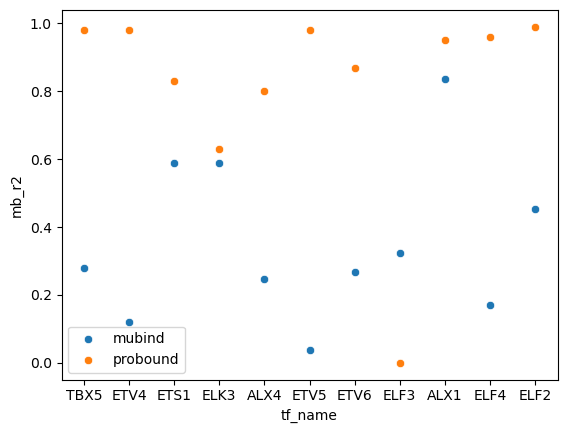

In [14]:
# simple scatter plot
sns.scatterplot(results, x='tf_name', y='mb_r2', label='mubind')
sns.scatterplot(results, x='tf_name', y='pb_r2', label='probound')